In [1]:
import json
import requests
import random
import string
import secrets
import time
import re
import collections
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.utils import to_categorical
# tf.compat.v1.disable_eager_execution()
# tf.compat.v1.experimental.output_all_intermediates(True)
# import tensorflow.compat.v1 as tf 
# import tensorflow.compat.v1.keras.layers as tfl
try:
    from urllib.parse import parse_qs, urlencode, urlparse
except ImportError:
    from urlparse import parse_qs, urlparse
    from urllib import urlencode

from requests.packages.urllib3.exceptions import InsecureRequestWarning

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

C:\Users\aadit\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.0.0)/charset_normalizer (2.0.10) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
tf.keras.backend.clear_session()

# Hyperparameter Adjustment

In [3]:
current_learning_rate=0.01
n_epochs=50
n_samples=1024
decay_rate=0.5
model_test_fraction=1
clip_threshold_value=10
patience=100
optimizer=tf.keras.optimizers.Adam(learning_rate=current_learning_rate,clipnorm=clip_threshold_value)
# optimizer=tf.keras.optimizers.SGD(learning_rate=current_learning_rate,momentum=0.9,clipnorm=clip_threshold_value)
# optimizer=tf.keras.optimizers.Adam(learning_rate=current_learning_rate)
# optimizer='adam'

# Data Preparation


In [4]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [5]:
# words=[]
with open('words_250000_train.txt','r') as f:
    words=f.read()

In [6]:
word_list=words.split()

In [7]:
len(word_list)

227300

In [8]:
alphabet='abcdefghijklmnopqrstuvwxyz'

In [9]:
char_freq={letter:0 for letter in alphabet}
for word in word_list:
    for letter in word:
        char_freq[letter]+=1

In [10]:
char_freq=dict(sorted(char_freq.items(),key=lambda x:x[1],reverse=True))

In [11]:
char_to_ix={a:i+1 for i,a in enumerate(alphabet)}
char_to_ix['_']=27

In [12]:
char_to_ix

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '_': 27}

In [13]:
max_len=len(max(word_list,key=lambda x:len(x)))

In [14]:
max_len

29

In [15]:
word_as_char_list=[list(word) for word in word_list]

In [16]:
def word_to_idx(word_as_char_list):
    word_as_idx=[]
    idx_list=[]
    for w in word_as_char_list:
        for c in w:
            idx_list.append(char_to_ix[c])
        word_as_idx.append(idx_list)
        idx_list=[]
            
    
    word_as_idx
    
    word_array = np.array([sublist + [0] * (max_len - len(sublist)) for sublist in word_as_idx])
    
    return word_array

In [17]:
word_array=word_to_idx(word_as_char_list)
word_array=tf.convert_to_tensor(word_array,tf.float32)

In [18]:
def y_label_generator(row):
    a=np.unique(row[row>0]-1)
    b=np.zeros((26,))
    b[a]=1
    return b

In [19]:
def idx_to_char(a):
    alphabet=' abcdefghijklmnopqrstuvwxyz_'
    return alphabet[a]

In [20]:
import numpy as np

In [21]:
y=np.apply_along_axis(y_label_generator,axis=-1,arr=word_array.numpy().astype(np.int32))
y=tf.convert_to_tensor(y,tf.float32)

In [22]:
X=np.where(word_array>0,27,0)

In [23]:
X=to_categorical(X,num_classes=28)
X=tf.convert_to_tensor(X,tf.float32)


In [24]:
from sklearn.model_selection import train_test_split

In [25]:
data_size=X.shape[0]
data_indices=np.arange(data_size)

In [26]:
np.random.seed(42)

In [27]:
shuffled_indices=np.random.permutation(data_indices)

In [28]:
shuffled_indices=shuffled_indices[:int(model_test_fraction*data_size)]

In [29]:
train_size=int(0.99*data_size)
valid_size=int(0.995*data_size)
train_indices=tf.constant(shuffled_indices[:train_size],tf.int32)
valid_indices=tf.constant(shuffled_indices[train_size:valid_size],tf.int32)
test_indices=tf.constant(shuffled_indices[valid_size:],tf.int32)

In [30]:
train_indices

<tf.Tensor: shape=(225027,), dtype=int32, numpy=array([198013, 224830, 226090, ..., 134461, 157361, 102215])>

In [31]:
X_train = tf.gather(X, train_indices)
y_train = tf.gather(y, train_indices)
word_array_train = tf.gather(word_array, train_indices)

# Slicing for validation data
X_valid = tf.gather(X, valid_indices)
y_valid = tf.gather(y, valid_indices)
word_array_valid = tf.gather(word_array, valid_indices)

# Slicing for test data
X_test = tf.gather(X, test_indices)
y_test = tf.gather(y, test_indices)
word_array_test = tf.gather(word_array, test_indices)

In [32]:
y_guess = tf.zeros((tf.shape(X)[0], 26), dtype=tf.float32)

# Slicing for training, validation, and test data
y_guess_train = tf.gather(y_guess, train_indices)
y_guess_valid = tf.gather(y_guess, valid_indices)
y_guess_test = tf.gather(y_guess, test_indices)

# Initialize incorrect_guesses tensors
incorrect_guesses_train = tf.zeros(tf.shape(X_train)[0], dtype=tf.float32)
incorrect_guesses_valid = tf.zeros(tf.shape(X_valid)[0], dtype=tf.float32)
incorrect_guesses_test = tf.zeros(tf.shape(X_test)[0], dtype=tf.float32)

# Slicing word_array for training, validation, and test data
word_array_train = tf.gather(word_array, train_indices)
word_array_valid = tf.gather(word_array, valid_indices)
word_array_test = tf.gather(word_array, test_indices)

# Neural Network Specification

In [33]:
tf.keras.backend.clear_session()

In [34]:
def custom_loss(y_true, y_pred, auxiliary_input):
    # Define your loss computation based on y_true, y_pred, and auxiliary_input
    main_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    # Define how the auxiliary input contributes to the loss
    auxiliary_loss = tf.reduce_mean(tf.square(auxiliary_input))
    
    # Combine main loss and auxiliary loss as needed
    total_loss = main_loss + 0.25 * auxiliary_loss  # Adjust weight as needed
    
    return total_loss

In [38]:
X_in=tfl.Input(shape=(29,28),name='game state')
previous_guesses=tfl.Input(shape=(26,),name='previous guesses')
x_=tfl.Masking(mask_value=0)(X_in)
x_=tfl.Conv1D(128,5,activation='relu',padding='same')(x_)
# x_=tfl.Conv1D(128,5,activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x_)
x_=tfl.MaxPool1D(2,padding='valid')(x_)
x_=tfl.BatchNormalization()(x_)
x_=tfl.Bidirectional(tfl.LSTM(64,return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)))(x_)
x_=tfl.BatchNormalization()(x_)
x_ = tfl.Dropout(0.5)(x_)
# x_=tfl.MultiHeadAttention(num_heads=4,key_dim=32,value_dim=32)(x_,x_)
x_=tfl.Attention()([x_,x_,x_])
x_=tfl.LSTM(64, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x_)
x_=tfl.BatchNormalization()(x_)
x_ = tfl.Dropout(0.5)(x_)
x_=tfl.Concatenate(axis=-1)([x_,previous_guesses])
x_=tfl.Dense(256,activation='relu')(x_)
x_=tfl.Dropout(0.5)(x_)
x_=tfl.Dense(26,activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x_)
output=x_
model=tf.keras.Model(inputs=[X_in,previous_guesses],outputs=output)
# model.compile(optimizer=optimizer,loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, incorrect_guesses),metrics=['accuracy'])

In [39]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 game state (InputLayer)     [(None, 29, 28)]             0         []                            
                                                                                                  
 masking_1 (Masking)         (None, 29, 28)               0         ['game state[0][0]']          
                                                                                                  
 conv1d_1 (Conv1D)           (None, 29, 128)              18048     ['masking_1[0][0]']           
                                                                                                  
 max_pooling1d_1 (MaxPoolin  (None, 14, 128)              0         ['conv1d_1[0][0]']            
 g1D)                                                                                       

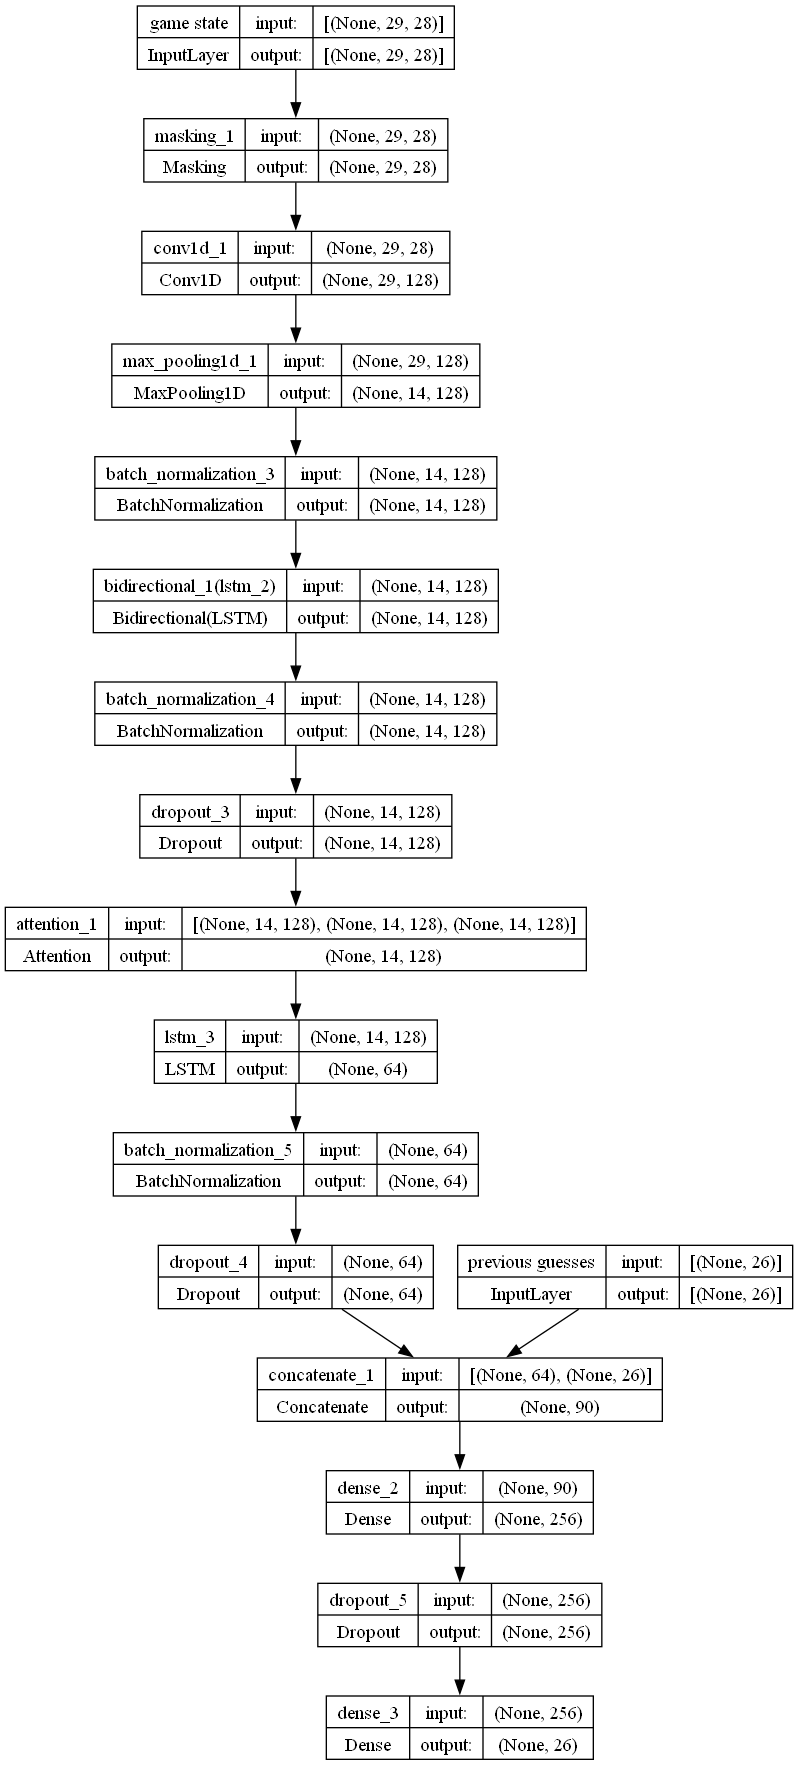

In [40]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

# learning rate decay

In [38]:
def lr_decay(current_learning_rate,decay_rate=decay_rate):
    return current_learning_rate*decay_rate

In [39]:
best_weights=model.get_weights()
best_loss=float('inf')
lr_patience=0

In [40]:
# model.set_weights(best_weights)

# Agent

In [41]:
class HangmanPlayer3:
    def __init__(self,X,y,y_guess,incorrect_guesses,model,word_array,n_lives=6):
        self.X=X
        self.word_array=word_array
        self.y=y
        self.y_guess=y_guess
        self.incorrect_guesses=incorrect_guesses
        self.non_zero_rows=tf.zeros((1,))
        self.non_zero_guesses=tf.zeros((1,))
        self.y_pred=tf.zeros((1,))
        self.loss,self.accuracy=(0,0)
        self.n_lives=tf.ones((tf.shape(self.X)[0],))*n_lives
        self.z=model
        self.X_buffer=self.X
        self.word_array_buffer=self.word_array
        self.y_buffer=self.y
        self.y_guess_buffer=self.y_guess
        self.incorrect_guesses_buffer=self.incorrect_guesses
        self.y_pred_buffer=tf.zeros((tf.shape(X)[0],26))
        self.n_lives_buffer=self.n_lives
        self.backprop_filter=tf.zeros((1,))
        self.flag=True
        self.wins=0
    def forward_prop(self):
        self.y_pred=self.z((self.X,self.y_guess))
    def compute_loss(self,predictions):
        return custom_loss(self.y_buffer[self.backprop_filter]/tf.reduce_sum(self.y_buffer[self.backprop_filter],axis=-1,keepdims=True),predictions,self.incorrect_guesses_buffer[self.backprop_filter])
    def backward_prop(self):
        global best_loss,best_weights,lr_patience,optimizer,current_learning_rate
        # print(self.X_buffer.shape,self.y_buffer.shape,self.y_pred_buffer.shape)
        with tf.GradientTape() as tape:
            predictions=self.z((self.X_buffer[self.backprop_filter], self.y_guess_buffer[self.backprop_filter]))
            loss= self.compute_loss(predictions)
        gradients=tape.gradient(loss,self.z.trainable_variables)
        optimizer.apply_gradients(zip(gradients,self.z.trainable_variables))
        self.loss=tf.reduce_mean(loss).numpy()
        # self.loss,self.accuracy=self.z.train_on_batch((self.X_buffer[self.backprop_filter],self.y_guess_buffer[self.backprop_filter]),self.y_buffer[self.backprop_filter]/np.sum(self.y_buffer[self.backprop_filter],axis=-1,keepdims=True))
        # # self.loss,self.accuracy=self.z.train_on_batch((self.X_buffer[self.backprop_filter],self.y_guess_buffer[self.backprop_filter]),self.y_buffer[self.backprop_filter]/np.sum(self.y_buffer[self.backprop_filter],self.incorrect_guesses_buffer[self.backprop_filter],axis=-1,keepdims=True))

        # if self.loss<best_loss:
        #     best_loss=self.loss
        #     best_weights=self.z.get_weights()
        # else:
        #     lr_patience+=1
    def update_parameters(self):
        # get the prediction from the model
        # add self.non_zeros filter for all the updates
        # y_pred=self.forward_prop()
        
        # get the value of the prediction
        max_indices_per_row=tf.argmax(self.y_pred,axis=-1)
        result_array=tf.cast(tf.one_hot(max_indices_per_row,depth=26),tf.float32)
        
        # get the correct guess positions
        correct_guesses=tf.multiply(result_array,self.y)
        correct_guess_indices=tf.reduce_any(correct_guesses!=0,axis=-1)

        # update y
        self.y=tf.where(tf.expand_dims(self.n_lives>0,axis=-1),tf.subtract(self.y,correct_guesses),self.y)
        
        # update incorrect_guesses array
        self.incorrect_guesses=tf.tensor_scatter_nd_update(self.incorrect_guesses,tf.where(~correct_guess_indices),self.incorrect_guesses[~correct_guess_indices]+1)

        #update y_guess array
        self.y_guess=tf.cast(tf.cast(self.y_guess,tf.int32) | tf.cast(result_array,tf.int32),tf.float32)
        
        # update X
        # get the places where the updates are to be made
        update_pred_values=tf.cast(tf.argmax(result_array,axis=-1)+1,tf.float32)
        update_mask=tf.logical_and(tf.equal(self.word_array,update_pred_values[...,tf.newaxis]),correct_guess_indices[:,tf.newaxis])

        # update x
        self.X = tf.where(tf.logical_and((self.n_lives>0)[...,tf.newaxis,tf.newaxis],update_mask[..., tf.newaxis]), tf.one_hot(tf.cast(update_pred_values,tf.int32), depth=28)[:, tf.newaxis, :], self.X)
        # update n_lives
        self.n_lives = tf.tensor_scatter_nd_update(self.n_lives, tf.where(tf.logical_and(~correct_guess_indices, self.n_lives > 0)), self.n_lives[tf.logical_and(~correct_guess_indices, self.n_lives > 0)] - 1)
     
    def update_buffer(self):
        if tf.reduce_any(self.n_lives>0,axis=-1):
            self.X_buffer = tf.concat([self.X_buffer, self.X], axis=0)
            self.y_buffer = tf.concat([self.y_buffer, self.y], axis=0)
            self.y_guess_buffer = tf.concat([self.y_guess_buffer, self.y_guess], axis=0)
            self.word_array_buffer = tf.concat([self.word_array_buffer, self.word_array], axis=0)
            self.n_lives_buffer = tf.concat([self.n_lives_buffer, self.n_lives], axis=0)
            self.incorrect_guesses_buffer = tf.concat([self.incorrect_guesses_buffer, self.incorrect_guesses], axis=0)
            # if tf.logical_and(tf.reduce_all(self.y==0,axis=-1),self.n_lives>0):
    def compute_win_rate(self):
        mask=tf.reduce_all(self.y==0,axis=-1)
        wins=tf.reduce_sum(tf.cast(mask,tf.int32)).numpy()
        total=tf.shape(self.y).numpy()[0]
        win_rate=wins/total
        return win_rate
    def compute_backprop_filter(self):
        self.non_zero_rows = tf.reduce_any(self.y_buffer != 0, axis=-1)
        self.non_zero_guesses = tf.reduce_any(self.y_guess_buffer != 0, axis=-1)
        self.backprop_filter = tf.logical_and(tf.logical_and(self.n_lives_buffer > 0, self.non_zero_rows), self.non_zero_guesses)
    def train_mode(self):
        self.play_mode()
            # print(f"loss: {self.loss}, accuracy: {self.accuracy}") 
            # print(self.X)
            # print(self.X.argmax(axis=-1))
            # print(self.n_lives)
        self.compute_backprop_filter()
        self.backward_prop()
        return(self.loss,self.compute_win_rate())
    def play_mode(self):
        while tf.reduce_any(self.n_lives>0,axis=-1):
            self.forward_prop()
            self.update_parameters()
            self.update_buffer()
    def inference_mode(self):
        self.play_mode()
        self.compute_backprop_filter()
        self.loss=tf.reduce_mean(self.compute_loss(self.z((self.X_buffer[self.backprop_filter], self.y_guess_buffer[self.backprop_filter])))).numpy()
        return(self.loss,self.compute_win_rate())
    def play_by_play(self,idx):
        guess_sequence=[[]]
        batch_len=tf.shape(self.X)[0]
        print(tf.shape(self.y_guess_buffer))
        for i in tf.range(idx, tf.shape(self.X_buffer)[0], batch_len):
            guess_sequence.append(list(np.where(self.y_guess_buffer.numpy()[i] == 1)[0]))
        # print(guess_sequence)
        for i,l in zip(range(idx,tf.shape(self.X_buffer)[0],batch_len),range(len(guess_sequence))):
            next_guess=set(guess_sequence[l+1])-set(guess_sequence[l])
            print("saw :",' '.join([idx_to_char(tf.argmax(self.X_buffer,axis=-1).numpy()[i][j]) for j in range(max_len)])," and guessed ", [idx_to_char(j+1) for j in next_guess] )
        # print(self.n_lives)
        # print(self.y_guess.argmax(axis=-1))
        # print(self.y_pred_buffer.argmax(axis=-1))


# Initialize Agent and training loop

In [42]:
from tqdm import tqdm

In [43]:
train_loss=0
train_win_rate=0
train_losses=[]
train_win_rates=[]
test_losses=[]
test_win_rates=[]

In [44]:
best_win_rate=0

In [ ]:
n_iter=len(X_train)//n_samples
num_examples=tf.shape(X_train)[0]
for i in tqdm(range(n_epochs)):
    train_loss=0
    train_win_rate=0
    
    indices = tf.range(num_examples, dtype=tf.int32)
    
    # Shuffle the indices
    shuffled_indices = tf.random.shuffle(indices)
    
    # Use the shuffled indices to shuffle the tensor
    X_train = tf.gather(X_train, shuffled_indices)
    y_train = tf.gather(y_train, shuffled_indices)
    y_guess_train = tf.gather(y_guess_train, shuffled_indices)
    incorrect_guesses_train = tf.gather(incorrect_guesses_train, shuffled_indices)
    word_array_train = tf.gather(word_array_train, shuffled_indices)
    for j in tqdm(range(n_iter)):
        a=j*n_samples
        b=min((j+1)*n_samples,data_size)
        X_sample,y_sample,y_guess_sample,incorrect_guesses_sample,word_array_sample=X_train[a:b],y_train[a:b],y_guess_train[a:b],incorrect_guesses_train[a:b],word_array_train[a:b]
    
        hangmanplayer=HangmanPlayer3(X_sample,y_sample,y_guess_sample,incorrect_guesses_sample,model,word_array_sample)
        loss,win_rate=hangmanplayer.train_mode()
        # if lr_patience==patience:
        #     # model.set_weights(best_weights)
        #     current_learning_rate=lr_decay(current_learning_rate)
        #     optimizer.learning_rate.assign(current_learning_rate)
        #     # print(self.z.optimizer.learning_rate)
        #     lr_patience=0
        # if j%10==0:
        #     hangmanplayer.play_by_play(0)
        print(f"mean loss:{loss}, mean win rate:{win_rate}")
        train_loss+=loss/n_iter
        train_win_rate+=win_rate/n_iter
    print(f"train loss:{train_loss}, train win rate:{train_win_rate}")
    train_losses.append(train_loss)
    train_win_rates.append(train_win_rate)
    hangmanplayer=HangmanPlayer3(X_test,y_test,y_guess_test,incorrect_guesses_test,model,word_array_test)
    loss,win_rate=hangmanplayer.inference_mode()
    print(f"test loss:{loss}, test win rate:{win_rate}")
    test_losses.append(loss)
    test_win_rates.append(win_rate)
    if win_rate>best_win_rate:
        best_win_rate=win_rate
        best_weights=model.get_weights()
current_weights=model.get_weights()

# Evaluation

In [56]:
model.set_weights(best_weights)

In [57]:
hangmanplayer=HangmanPlayer3(X_test,y_test,y_guess_test,incorrect_guesses_test,model,word_array_test)
loss,win_rate=hangmanplayer.inference_mode()
print(f"test loss:{loss}, test win rate:{win_rate}")

test loss:1.6467009782791138, test win rate:0.6007036059806509


In [58]:
hangmanplayer=HangmanPlayer3(X_valid,y_valid,y_guess_valid,incorrect_guesses_valid,model,word_array_valid)
loss,win_rate=hangmanplayer.inference_mode()
print(f"test loss:{loss}, test win rate:{win_rate}")

test loss:1.6330795288085938, test win rate:0.5950704225352113


In [59]:
model.set_weights(current_weights)
model.save_weights('current_weights.h5')

In [60]:
model.set_weights(best_weights)
model.save_weights('best_weights.h5')

In [61]:
len(train_losses),len(test_losses)

(70, 70)

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

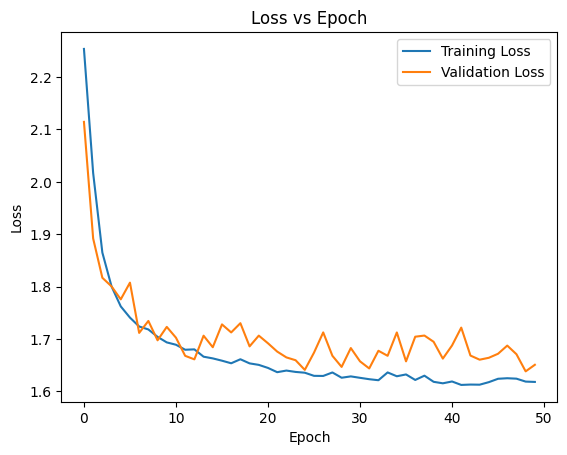

In [63]:
plt.plot(range(len(train_losses[:50])),pd.Series(train_losses[:50]),label='Training Loss')
plt.plot(range(len(test_losses[:50])),pd.Series(test_losses[:50]),label = 'Validation Loss')
plt.legend()
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('loss_vs_epoch.jpg')
plt.show()

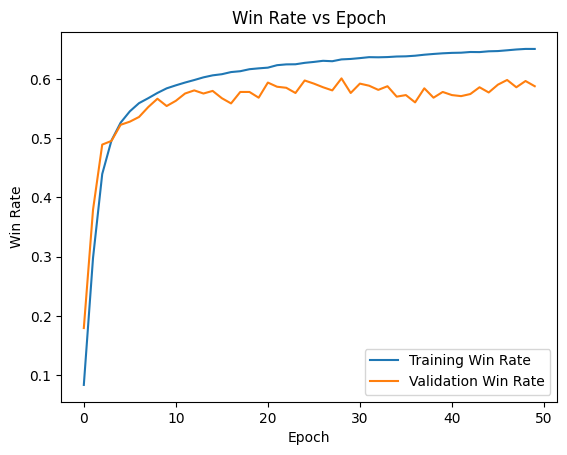

In [64]:
plt.plot(range(len(train_win_rates[:50])),pd.Series(train_win_rates[:50]),label='Training Win Rate')
plt.plot(range(len(test_win_rates[:50])),pd.Series(test_win_rates[:50]),label = 'Validation Win Rate')
plt.legend()
plt.title('Win Rate vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Win Rate')
plt.savefig('win_rate_vs_epoch.jpg')
plt.show()

# Notes

- [x] experiment with complexity of model
- [x] parallelization for training 
- [x] add validation method in hangman class
- [x] penalize for number of attempts
- [x] research loss techniques
- [x] learning rate decay
- [-] an alternate approach is for the entire corpus play one correct move, etc etc
- [x] make it an accuracy based selection